In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data = pd.read_csv('census_data.csv')

C:\Users\tkrec\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,time_series_code,date,value
0,BOPGS_BAL_US_adj,1992-01-01,-2026
1,BOPGS_EXP_US_adj,1992-01-01,50251
2,BOPGS_IMP_US_adj,1992-01-01,52277
3,BOPG_BAL_US,1992-01-01,-6210
4,BOPG_EXP_US,1992-01-01,33953


In [4]:
data.rename(columns = {'time_series_code': 'tsc'}, inplace=True)

In [5]:
rental_codes = []
home_ownership_codes = []

for region_abb in ('US', 'NE', 'MW', 'SO', 'WE'):
    rental_codes += ['RATE_RVR_' + region_abb]
    home_ownership_codes += ['RATE_HVR_' + region_abb]

In [6]:
rental_vacancies = data.loc[data['tsc'].isin(rental_codes), :].copy()
home_ownership = data.loc[data['tsc'].isin(home_ownership_codes), :].copy()

In [7]:
rental_vacancies['region'] = rental_vacancies.tsc.str.slice(-2)
home_ownership['region'] = home_ownership.tsc.str.slice(-2)

In [8]:
rental_vacancies.drop(columns=['tsc'], axis=1, inplace=True)
home_ownership.drop(columns=['tsc'], axis=1, inplace=True)

In [9]:
rental_vacancies.rename(columns = {'value': 'rv_perc'}, inplace=True)
home_ownership.rename(columns = {'value': 'ho_perc'}, inplace=True)

In [10]:
rental_vacancies.head()

,date,rv_perc,region
1848,1956-01-01,6.2,US
1849,1956-01-01,3.3,NE
1850,1956-01-01,5.2,MW
1851,1956-01-01,7.9,SO
1852,1956-01-01,9.7,WE


In [11]:
home_ownership.head()

,date,ho_perc,region
1853,1956-01-01,1.0,US
1854,1956-01-01,0.7,NE
1855,1956-01-01,0.7,MW
1856,1956-01-01,1.0,SO
1857,1956-01-01,1.4,WE


In [12]:
rental_vacancies['idx'] = rental_vacancies.date + rental_vacancies.region
home_ownership['idx'] = home_ownership.date + home_ownership.region

In [13]:
rental_vacancies.head()

,date,rv_perc,region,idx
1848,1956-01-01,6.2,US,1956-01-01US
1849,1956-01-01,3.3,NE,1956-01-01NE
1850,1956-01-01,5.2,MW,1956-01-01MW
1851,1956-01-01,7.9,SO,1956-01-01SO
1852,1956-01-01,9.7,WE,1956-01-01WE


In [14]:
home_ownership.head()

,date,ho_perc,region,idx
1853,1956-01-01,1.0,US,1956-01-01US
1854,1956-01-01,0.7,NE,1956-01-01NE
1855,1956-01-01,0.7,MW,1956-01-01MW
1856,1956-01-01,1.0,SO,1956-01-01SO
1857,1956-01-01,1.4,WE,1956-01-01WE


In [15]:
rental_vacancies.set_index('idx', inplace=True)
home_ownership.set_index('idx', inplace=True)

In [16]:
home_ownership.drop(columns = ['region', 'date'], axis=1, inplace=True)

In [17]:
rv_ho_combined = pd.concat([rental_vacancies, home_ownership], axis=1)[['date', 'region', 'ho_perc', 'rv_perc']]

In [18]:
rv_ho_combined.head()

,date,region,ho_perc,rv_perc
idx,,,,
1956-01-01US,1956-01-01,US,1.0,6.2
1956-01-01NE,1956-01-01,NE,0.7,3.3
1956-01-01MW,1956-01-01,MW,0.7,5.2
1956-01-01SO,1956-01-01,SO,1.0,7.9
1956-01-01WE,1956-01-01,WE,1.4,9.7


In [19]:
rv_ho_combined.dtypes

date       object
region     object
ho_perc    object
rv_perc    object
dtype: object

In [20]:
rv_ho_combined['date'] = pd.to_datetime(rv_ho_combined.date)
rv_ho_combined['region'] = rv_ho_combined.region.astype('category')
rv_ho_combined['ho_perc'] = rv_ho_combined.ho_perc.astype(float)
rv_ho_combined['rv_perc'] = rv_ho_combined.rv_perc.astype(float)

In [21]:
rv_ho_combined.region.cat.categories

Index(['MW', 'NE', 'SO', 'US', 'WE'], dtype='object')

In [22]:
rv_ho_combined.dtypes

date       datetime64[ns]
region           category
ho_perc           float64
rv_perc           float64
dtype: object

In [23]:
rv_ho_combined['year'] = rv_ho_combined.date.dt.year
rv_ho_combined['quarter'] = rv_ho_combined.date.dt.quarter

In [24]:
rv_ho_combined.head()

,date,region,ho_perc,rv_perc,year,quarter
idx,,,,,,
1956-01-01US,1956-01-01,US,1.0,6.2,1956,1
1956-01-01NE,1956-01-01,NE,0.7,3.3,1956,1
1956-01-01MW,1956-01-01,MW,0.7,5.2,1956,1
1956-01-01SO,1956-01-01,SO,1.0,7.9,1956,1
1956-01-01WE,1956-01-01,WE,1.4,9.7,1956,1


In [30]:
rv_ho_combined[rv_ho_combined.date >= pd.to_datetime('1/1/2015')].groupby('region').ho_perc.agg(['min', 'max', 'mean'])

,min,max,mean
region,,,
MW,1.4,1.9,1.64
NE,1.4,2.0,1.79
SO,1.8,2.2,2.06
US,1.5,1.9,1.77
WE,1.2,1.5,1.35


In [40]:
hop = rv_ho_combined[rv_ho_combined.region != 'US'].ho_perc
rvp = rv_ho_combined[rv_ho_combined.region != 'US'].rv_perc

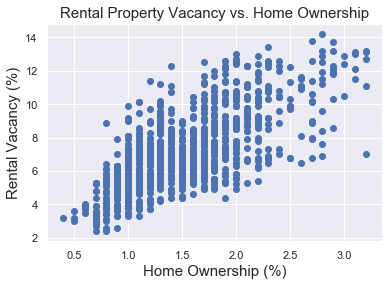

In [41]:
plt.scatter(hop, rvp)
plt.title('Rental Property Vacancy vs. Home Ownership', fontsize=15)
plt.xlabel('Home Ownership (%)', fontsize=15)
plt.ylabel('Rental Vacancy (%)', fontsize=15)
plt.show()

In [43]:
x = sm.add_constant(hop)
results = sm.OLS(rvp, x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rv_perc   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     933.1
Date:                Sun, 14 Jun 2020   Prob (F-statistic):          1.35e-144
Time:                        23:48:18   Log-Likelihood:                -1877.9
No. Observations:                 984   AIC:                             3760.
Df Residuals:                     982   BIC:                             3770.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5689      0.162     15.890      0.000       2.252       2.886
ho_perc        3.0364      0.099     30.547      0.000       2.841       3.231
==============================================================================
Omnibus:                       15.923   Durbin-Watson:                   1.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.243
Skew:                           0.308   Prob(JB):                     0.000297
Kurtosis:                       3.129   Cond. No.                         6.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

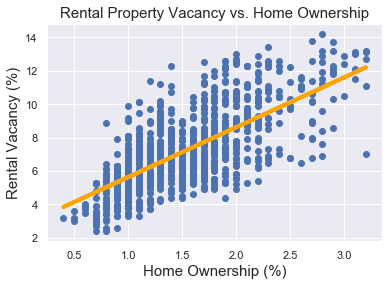

In [44]:
plt.scatter(hop, rvp)
rvhat = 2.6508 + 2.983 * hop
fig = plt.plot(hop, rvhat, lw=4, c='orange')
plt.title('Rental Property Vacancy vs. Home Ownership', fontsize=15)
plt.xlabel('Home Ownership (%)', fontsize=15)
plt.ylabel('Rental Vacancy (%)', fontsize=15)
plt.show()